# Recurrent Neural Network

**RNNs** are deep learning models that capture the dynamics of sequences via *recurrent* connections (cycles in the network of nodes). They have advantages of flexibility in handling data of varying length and the ability to make sequential predictions useful for NLP, time-series analysis and video analysis.

Conventional machine learning models have concerned with single feature vector $x\in\mathbb{R^d}$ of fixed length $d$. RNN and relevant ideas are capable of processing sequence of data, namely an ordered list of feature vectors, $x_1, ..., x_T$, where each feature vector $x_i$ is indexed with a time step $t\in \mathbb{Z}^+$. 

Though the entire sample data is drawn from a hypothetical distribution, we do not assume that adjacent feature vectors are independent from each other. Model type varies based on the actual structure of the observations and targetes. **Aligned** model make a prediction for each input, while **unaligned** model may predict a sequence of target from one input or one target for a sequence of data. 

##  Autoregressive Model
Given the historical data $x_1,..,x_{t-1}$, we are interested in $P(x_t|x_1,...,x_{t-1})$. We may focus on the summary statistics $E[P(x_t|x_1,...,x_{t-1})]$. Based on the belif of unneccessity to trace back the history to far, we define some $\tau\in \mathbb{Z}^+$ and focus on $x_{t-\tau}, ...,x_{t-1}$. The model also creates some latent summary statistics $h_t$ of the past observations. Then,$\hat x_t = P(x_t | h_t)$ and $h_t = g(h_{t-1}, x_{t-1})$.

## Sequence Model

When working with discrete data, we wish to estimate the joint probability of an entire sequence. Sequence model is identical to the autoregressive model since
$$
P(x_1,...X_T) = P(x_1)\prod^T_{t=2}P(x_t|x_{t-1},...,x_1)
$$


## Markov Model

Whenever keeping only recent data in time $\tau$ does lose predictive power, we say that the sequence satisfies a *Markov coondition*, and call it $\tau$-th order Markov model. Then, a markov model is a simplified sequence model.

## Markov Model Example:

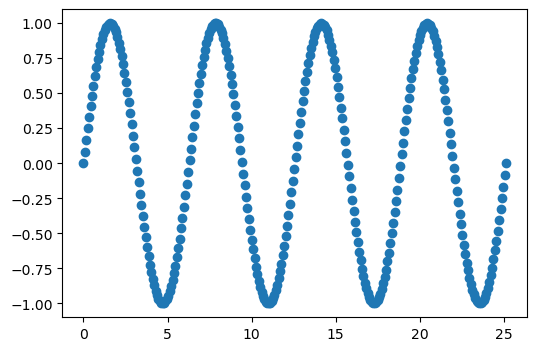

In [1]:
import torch
import dl
import matplotlib.pyplot as plt
import numpy as np

TAU = 40
class CosineData(dl.DataModule):
    def __init__(self, batch_size=32, T=300, num_train=250, tau=4):
        self.save_hyperparameters()
        self.time = np.linspace(0, 8*np.pi, T)
        self.x = torch.sin(torch.tensor(self.time))

    def get_dataloader(self, train=True):
        if train:
            indices = list(range(0, self.num_train-self.tau-1, 1))
        else:
            indices = list(range(self.num_train, self.time.shape[0]-self.tau-1, 1))

        yield (
            torch.stack([self.x[offset:indices[-1]+offset] for offset in range(self.tau)], dim=1),
            self.x[self.tau:indices[-1]+self.tau].reshape(-1, 1)
        )

data = CosineData(tau=TAU)
plt.scatter(data.time, data.x);

In [2]:
class LinearRegression(dl.Module):
    def __init__(self, P, eta, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(P, 4, dtype=torch.float64),
            torch.nn.Linear(4, 1, dtype=torch.float64)
            )

    def init_params(self):
        for p in self.net.parameters():
            torch.init.normal_(p, mean=0, std=self.sigma)

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2
        return l.mean()

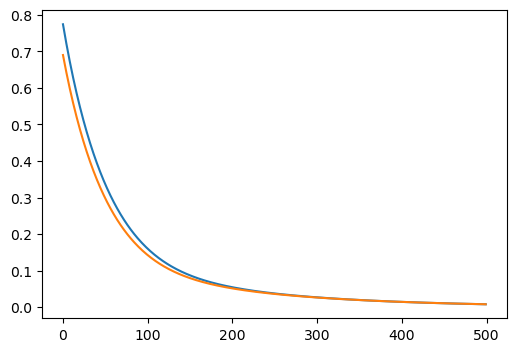

In [3]:
trainer = dl.Trainer(500)
model = LinearRegression(TAU, 0.001)
trainer.fit(model, data)
trainer.plot_loss()

### Intrapolation

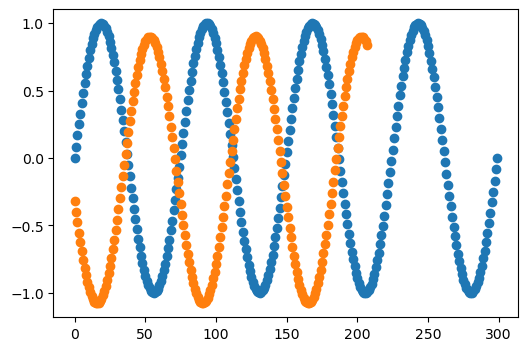

In [4]:
plt.scatter(range(len(data.x)), data.x)
x_hat = torch.concat([model(X) for X,y in data.get_dataloader()]).detach().numpy().flatten()
plt.scatter(range(len(x_hat)), x_hat)

Thus, a simple linear regression fit the noisy training cosine curve reasonably well although it also fit the noise. Now we observe how it generalizes to the unseen data. Notice that the model relies on $x$ to predict $\hat x$. Thus, the technique for making successive prediction is
$$\hat x_t = f(\hat x_{t-\tau-1}, ...,\hat x_{t-1})$$

### Extrapolation

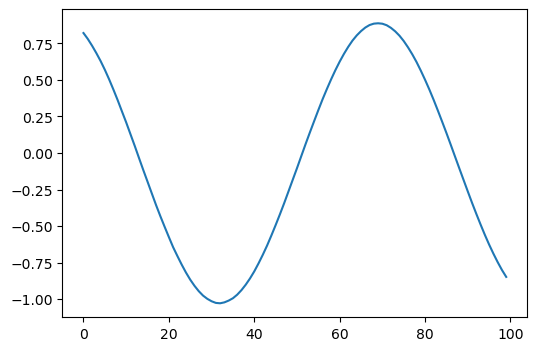

In [5]:
x = torch.tensor(x_hat[-TAU:]).reshape(1,-1)
x_hat_future = []
for n in range(100):
    output = model(x)
    x_hat_future.append(output.item())
    x = torch.tensor(list(x.numpy()[0])[-TAU+1:] + [output.item()]).reshape(1,-1)
plt.plot(range(len(x_hat_future)), x_hat_future);

Observe that without input data, the model is capable of capturing the overall trend. The dramatic deviation from the actual curve is due to the accumulation of error terms as $T$ grows.

## Recurrent Neural Network

Recurrent neural network refers to layer that feed in a summary information of previous observations to make the current prediction. At time step $t$, the network maintains a fixed function to compute the hidden state $h_t$. For a minibatch examples $X\in\mathbb{R}^{n\times d}$, the hidden layer output $H\in\mathbb{R}^{n\times h}$ is calculated as 
$$
H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_h)
$$
Next, using the hidden state, we can make prediction by
$$
O_t = H_tW_{hq} + b_q
$$
similar to regular MLP.

**Remark**: The calculation of $X_tW_{xh} + H_{t-1}W_{hh}$ is equivalent to $ concat(X_t, H_{t-1}) \times concat(W_{xh}, W_{hh})$. (not proven)

**Remark**: In order to exploit the full potential of the hidden states, an entire sequence should be fed into the model. RNN would fail to extrapolate if trained on a segment of the sequence.

In [97]:
import torch.nn as nn

@dl.add_to_class(CosineData())
def get_dataloader(self):
    return self.x[:self.num_train-1], self.x[1:self.num_train]

class RNN_Cell(nn.Module): 
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # we randomly initialize our trainable parameters
        self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size, dtype=torch.float64))
        self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size, dtype=torch.float64))

        self.b = torch.nn.Parameter(torch.randn(hidden_size, dtype=torch.float64))

    def forward(self, x_t, state):

        h_prev = state

        # here, we simply write down the equations from the figure above
        # in the pytorch 'language'
        a = torch.mm(x_t, self.U) + torch.mm(h_prev, self.W) + self.b
        h = torch.sigmoid(a)

        return h
    
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        # This is our missing equation from before, 
        # in Torch the feed-forward layers are called Linear
        self.linear = nn.Linear(hidden_size, 1, dtype=torch.float64) 

    def init_hidden(self,):
        # we will initialize our hidden state with zeros
        return torch.zeros(1,self.hidden_size, dtype=torch.float64) 
    
    def forward(self, X, h=None):
        self.h = self.init_hidden() if h is None else h
        outputs = []

        # we will process the sequence here
        for X_t in X:

            self.h = self.rnn_cell.forward(X_t, self.h)

            y_t = self.linear.forward(self.h)
            outputs.append(y_t)

        return torch.stack(outputs), self.h

In [106]:
model = RNN(1, 10)
optim = torch.optim.Adam(model.parameters(), 0.01)
loss = torch.nn.MSELoss()
data = CosineData(num_train=250)

for epoch in range(300):
    optim.zero_grad()
    x, y = next(data.get_dataloader())
    y_hat, _ = model(x)
    l = loss(y_hat, y)
    l.backward()
    optim.step()
    
    if epoch%10==0:
        print(f'loss: {l.item()}')

loss: 0.6424845255258723
loss: 0.4143173227361964
loss: 0.23401322695677815
loss: 0.07256549336445237
loss: 0.04821472736137575
loss: 0.02584219228750594
loss: 0.018651608405846738
loss: 0.012805958973905239
loss: 0.009694241650872758
loss: 0.007297035396455078
loss: 0.0054746041723209285
loss: 0.004115319396806977
loss: 0.0030605580403708886
loss: 0.0022516414339294457
loss: 0.0016723563260786763
loss: 0.001298376056412324
loss: 0.0010809751709104868
loss: 0.0009574675939642472
loss: 0.0008766529774884341
loss: 0.000813607403739685
loss: 0.0007609568974152519
loss: 0.0007158689288553335
loss: 0.0006758879545234425
loss: 0.0006394705863805938
loss: 0.0006059322821362829
loss: 0.0005748837171025035
loss: 0.0005460074404113713
loss: 0.0005190376524290738
loss: 0.0004937514732640236
loss: 0.0004699583620657209


### Intrapolation

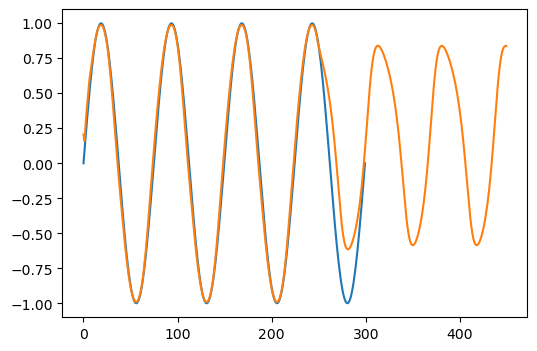

In [107]:
with torch.no_grad():
    predicted_x, state = model(data.x[:data.num_train].reshape(-1, 1, 1))
    predicted_x = predicted_x.flatten()

    real_x = data.x
    future_x = []
    x = predicted_x[-1].reshape(-1,1,1)
    for i in range(200):
        x, state = model(x, state)
        future_x.append(x.item())

plt.plot(real_x)
plt.plot(list(predicted_x) + future_x)

As the result above suggests, a depth-2 recurrent neural network is able to fit a sine function and maintain a good extrapolation accuracy, which outperforms a simple regression model. However, a MLP with identity activation function can achieve equally good result in modeling certain functions. 

See 
- https://ai.stackexchange.com/questions/36488/entirely-linear-neural-network-learning-non-linear-function/36489#36489
- https://www.kaggle.com/code/seangribben/lstm-time-series-prediction-pytorch-sine-wave/notebook

## Gradient Clipping

## Backpropagation Through Time